# Let's get the data!

Welcome to the inaugural blog post!

In this blog we'll cover how we imported the dataset into a python coding environment, and readied the dataframe for analysis and visualisation. 

Before starting, we've downloaded the bicycle volume and speed data located on the DataVic site here:
https://discover.data.vic.gov.au/dataset/bicycle-volume-and-speed

The data shows cycling flows in both directions recorded at 42 off-road counter sites and 4 on-road counter sites in Melbourne.

The dataset is delivered in a large number of CSV files, with each file containing several days worth of data from one seonsor location. There's also an excel file called 'VicRoads_Bike_Site_Number_Listing' which indexes the location of each of the sensors. 

While the files could be programmatically unzipped with code, we unzipped them all using 7-zip in one big batch. Easy!

In [1141]:
# We'll be coding in Python using Jupyter notebook
# We'll start off by importing all the python libraries that we'll need in the one spot.

import pandas as pd
import numpy as np
import os
from collections import Counter
from tqdm.notebook import tqdm
import plotly.express as px
import geopandas as gpd
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap

In [1142]:
# Let's create a couple of variables for the operating system file paths to access the CSVs downloaded from DataVic.
# This will save time later on! 

# We'll also limit our data to the last 5 years, from 2017 to 2021

rootdir = '../../data/DPC/bicycle_flows/'
visuals = '../docs/visuals/bicycle_flows/'

data_years = [2017,2018,2019,2020,2021]
folder_prefix = 'Bicycle_Volume_Speed_'

## Data validation 

There's a lot of CSVs, so lets first make sure that each CSV has the same variables or columns.

Once this is confirmed, we'll be able to combine all of the individual CSVs into a dataframe.



In [1143]:
# This code iterates over each of the CSVs and tallies the number of unique column combinations. 

# Ideally, the result will be a single combination of columns, so we'll be able to append each to a
# new dataframe. Let's see!




#for year in data_years:
#    tally = pd.DataFrame(columns=["count","len"])
#    counter = 0
#    for subdir, dirs, files in tqdm(os.walk(rootdir)):
#        for file in files:
#            if ('.csv' in file) and ('.zip' not in file):
#            # read in CSV, if it contains records (which at least one doesn't!)
#                file_path = os.path.join(subdir,file) 
#                if os.path.getsize(file_path) > 0:
#                    df = pd.read_csv(os.path.join(subdir,file))
#                # store list of columns in variable df_columns as a string
#                    df_columns = f"{df.columns.to_list()}"
#                    # if CSV columns string is in the tally index, increment this
#                    if df_columns in tally.index:
#                        tally[tally.index==df_columns] += 1
#                        # otherwise add CSV columns string to the tally index
#                    else:
#                        tally.loc[df_columns] = 1
#                        # increment a counter; athough theoretically this should only sum to the sum of tallies!
#                        counter+=1
#
#print(counter)

In [1144]:
# Great, only 1 unique combo!

# Let's check out that combination of variables.

#tally

## Creating a dataframe

Now that we know that all of the CSVs share the same column names, we'll join the various files together to create a dataframe to run the analysis. 

In [1145]:
# We'll start by creating an empty dataframe list to put the data into, and then we'll 'go for a walk' through the operating system
# to pick up the files we want. We'll make sure we're only collecting CSVs & files that have data (ie, are larger than 0)

# TQDM is a wrapper which creates a processing progress bar - useful when there's a lot of files!

filename = 'combined_bicycle_summary'
analysis_period = 'W'

if os.path.exists(os.path.abspath(f'{filename}_{analysis_period}.csv')):
    df = pd.read_csv(os.path.abspath(f'{filename}_{analysis_period}.csv'), parse_dates = True)
else:
    df = {}
    for year in tqdm(data_years, unit = 'years'):
        csv_files = []
        for subdir, dirs, files in tqdm(os.walk(f'{rootdir}/{folder_prefix}{year}'),
                                        desc= f"Getting CSV file paths ({year})...",
                                        unit="CSVs",
                                        leave = False):
            for file in files:
                if ('.csv' in file) and ('.zip' not in file):
                    # record filepaths of CSVs containing records
                    file_path = os.path.join(subdir,file)
                    # let's make sure we only join files that contain data
                    if os.path.getsize(file_path) > 0:
                        csv_files.append(os.path.join(subdir,file))
        dfs=[]
        for csv in tqdm(csv_files,desc=f"Reading csv files for {year}...",unit="CSVs", leave = False):
            dfs.append(pd.read_csv(csv, index_col=None, header=0))
        # Here we'll create a new variable called 'month_year'. 
        # This will allow us to aggregate the daily data, which will hopefully cut down on the processing needed.
        dfs = pd.concat(dfs, axis=0, ignore_index=True)
        dfs['year_M'] = pd.to_datetime(dfs['DATE'],format='%d/%m/%Y').dt.to_period('M')
        dfs['year_W'] = pd.to_datetime(dfs['DATE'],format='%d/%m/%Y').dt.to_period('W')
        for period in ['M','W']:
            if period not in df.keys():
                df[period]=[]
            else:
                df[period].append(dfs[dfs[f'year_{period}'].dt.year==year]\
                          .groupby(['SITE_XN_ROUTE', 'LOC_LEG',f'year_{period}'])[['VEHICLE', 'SPEED','HEADWAY']]\
                          .agg({'VEHICLE': 'count',
                                'SPEED': 'mean',
                                'HEADWAY': 'mean'}).reset_index())
        del dfs
    for period in ['M','W']:
        df[period] = pd.concat(df[period], axis=0, ignore_index=True)
        # Next, we'll write the database to a CSV file so we won't need to rerun
        # the previous cell if the kernel is stopped at any point.
        df[period].to_csv(f'{filename}_{period}.csv',index=False,header=True)
    # read in the main analysis period of interest dataframe, overwriting the working dictionary 'df'
    df = pd.read_csv(f'{filename}_{analysis_period}',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15800 entries, 0 to 15799
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SITE_XN_ROUTE  15800 non-null  int64  
 1   LOC_LEG        15800 non-null  int64  
 2   year_W         15800 non-null  object 
 3   VEHICLE        15800 non-null  int64  
 4   SPEED          15800 non-null  float64
 5   HEADWAY        15661 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 740.8+ KB


## Summary statistics

Let's look at the summary statistics for the dataframe. Firstly we'll look at what type of data is included in each column. 

Then, we'll check the max/min values, and the distribution of the data, to see if there are any outlying data points. 

In [1146]:
# Older dataset
# dfo = pd.read_csv(os.path.abspath(f'{filename}_data.csv'),parse_dates=True)
# dfo.loc[dfo['month_year'].str.startswith(f'{year}')].groupby('month_year')['VEHICLE'].sum()

# the older and new month datasets are the same for the relevant years
# however, aggregating the weeks to months is apparently not valid - so that should be avoided
dfm = pd.read_csv(os.path.abspath(f'{filename}_M.csv'),parse_dates=True)
years = [2018,2019,2020,2021]
#for year in years:
#    for month in zip(df.loc[df.year==2018].groupby('month')['VEHICLE'].sum(),
#    dfm.loc[dfm['year_M'].str.startswith(f'{year}')].groupby('year_M')['VEHICLE'].sum()):
#        # print(month[0]-month[1])  ## Commented out, but this is different; don't aggregate weeks to months, has error

#print(dfo.loc[dfo['month_year']>='2018-01'].VEHICLE.sum())
print(dfm.VEHICLE.sum())
print(df.VEHICLE.sum())

45844711
46003328


In [1147]:
df.describe().round({"LOC_LEG":1,"SPEED":1,"HEADWAY":1})\
  .astype({"SITE_XN_ROUTE": int, "VEHICLE": int})


,SITE_XN_ROUTE,LOC_LEG,VEHICLE,SPEED,HEADWAY
count,15800,15800.0,15800,15800.0,15661.0
mean,16140,56763.5,2911,20.7,1229.2
std,11862,10620.7,2662,4.2,5779.3
min,6411,20082.0,1,1.2,0.0
25%,7592,59451.0,928,17.9,132.3
50%,9077,59472.0,2342,20.7,218.6
75%,32493,60963.0,4023,23.4,466.4
max,40005,70011.0,38238,34.8,86400.0


## Joining the sensor site index with the sensor data files

Now we that we have imported 5 years worth of sensor CSVs, let's join this dataframe to the site index file. This will allow us to map each sensor's data to its specific location.

Firstly we'll import the site index file and then we'll join the files on two columns. we'll need to use the merge function as the columns all have different names.

In [1148]:
# Let's open the site number listing file and check out the variables

sites = pd.read_excel(f'{rootdir}/VicRoads_Bike_Site_Number_Listing.xlsx')
sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SITE_ID        93 non-null     int64  
 1   TFM_ID         93 non-null     int64  
 2   STRT_LAT       93 non-null     float64
 3   STRT_LONG      93 non-null     float64
 4   GPS            92 non-null     object 
 5   SITE_NAME      91 non-null     object 
 6   LOCATION_DESC  93 non-null     object 
 7   SITE_DESC      93 non-null     object 
 8   TFM_DESC       93 non-null     object 
 9   BEARING_DESC   93 non-null     object 
 10  DATA_SRC_CD    93 non-null     object 
 11  RGN_SHORT_NM   93 non-null     object 
 12  Comments       75 non-null     object 
dtypes: float64(2), int64(2), object(9)
memory usage: 9.6+ KB


In [1149]:
# Now we'll view the summary statistics to check the data distribution for any outliers

sites.describe()

# Here it's good to look at the min and max values, particularly for any data errors in the latitude and longitudes. 
# They're looking good!

,SITE_ID,TFM_ID,STRT_LAT,STRT_LONG
count,93.000000,93.000000,93.000000,93.000000
mean,18008.935484,57763.236559,-37.832249,144.998457
std,12974.657259,10612.712297,0.112396,0.082142
min,6411.000000,20082.000000,-38.507720,144.736270
25%,7596.000000,59454.000000,-37.832280,144.973640
50%,9999.000000,59477.000000,-37.806770,144.987550
75%,32615.000000,61176.000000,-37.783990,145.028100
max,40005.000000,70011.000000,-37.743220,145.291100


In [1150]:
# Let's do a quick map to make sure the locations seem correct.



fig = px.scatter_mapbox(sites, lat="STRT_LAT", lon="STRT_LONG", hover_name="SITE_NAME", hover_data=["SITE_ID", "BEARING_DESC"],
                        color_discrete_sequence=["fuchsia"], zoom=10, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html(f'{visuals}Site_Map.html')
import plotly.io as pio
pio.write_image(fig, '../docs/images/Sensor_Site_Map.png', width=2000, height=800,scale=3)
fig.show()


## And now to the merging

In [1151]:
# Now we will merge the 'SITE_XN_ROUTE' column with the 'SITE_ID' column, while the 'LOC_LEG' column will be merged with 'TFM_ID'

# The 'SITE_ID' variable refers to the general site, while the 'TFM_ID' refers to individual sensors at that location.

# Most sites have 2 individual sensors to measure bi-directional bicycle flows.

df_merge = pd.merge(sites, dfm, left_on = ['SITE_ID','TFM_ID'], right_on = ['SITE_XN_ROUTE', 'LOC_LEG'])
df_merge.head()


,SITE_ID,TFM_ID,STRT_LAT,STRT_LONG,GPS,SITE_NAME,LOCATION_DESC,SITE_DESC,TFM_DESC,BEARING_DESC,DATA_SRC_CD,RGN_SHORT_NM,Comments,SITE_XN_ROUTE,LOC_LEG,year_M,VEHICLE,SPEED,HEADWAY
0,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-01,13909,23.954519,242.843590
1,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-02,16360,24.433380,186.140507
2,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-03,13984,24.392077,199.113508
3,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-04,17351,24.352354,194.343081
4,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-05,13397,24.588766,208.692588


## Recap

We have:
- confirmed that all the sensor data CSVs share the same variables
- combined each of the CSVs crom 2017 to 2021 into a dataframe
- created a new aggregate variable called 'month_year'
- looked at the distribution of data in both the dataframe and the site index file
- merged the sensor data and the site index file to create a 'mappable' dataset

The next blog will focus on the analysis and visualisation of this dataset - thanks for following along!

# Analysis & Visualisations

In [1152]:
# Let's create a new table which summarises bicycle volume by sensor and date

site_by_period = df_merge.groupby(['SITE_ID','year_M'])['VEHICLE'].sum().reset_index()
    
site_by_period.head()                 

,SITE_ID,year_M,VEHICLE
0,6411,2018-01,51487
1,6411,2018-02,66325
2,6411,2018-03,53528
3,6411,2018-04,62449
4,6411,2018-05,61984


In [1153]:
# Here we'll check out the vehicle volume distribution by month.

site_by_period.groupby('year_M')['VEHICLE'].describe()

# December 2017 is missing! 
# November 2021 has only partially been added so we'll remove that from our results.

,count,mean,std,min,25%,50%,75%,max
year_M,,,,,,,,
2018-01,36.0,29654.694444,21880.594751,678.0,15736.50,27303.5,42534.00,76811.0
2018-02,36.0,34214.138889,25025.261967,795.0,18770.50,29079.0,47395.00,86731.0
2018-03,36.0,27368.222222,20511.672688,603.0,13953.50,23748.0,36656.25,68447.0
2018-04,37.0,30931.405405,23915.848831,6.0,11817.00,26190.0,37063.00,79814.0
2018-05,37.0,27360.972973,22993.367194,223.0,9341.00,22260.0,33315.00,78118.0
2018-06,37.0,22721.702703,18600.631556,134.0,8255.00,18723.0,28393.00,61247.0
2018-07,37.0,10246.216216,8611.253513,99.0,2176.00,8582.0,14990.00,28574.0
2018-08,37.0,16738.351351,12849.104094,164.0,8173.00,14795.0,20729.00,43174.0
2018-09,37.0,26322.972973,19221.532977,1030.0,11865.00,22882.0,36264.00,69217.0


<AxesSubplot:xlabel='year_M'>

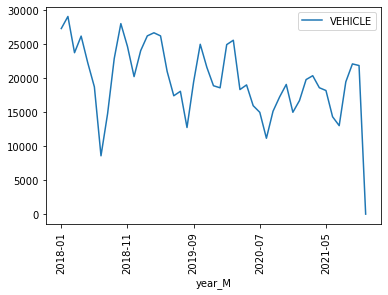

In [1154]:
# Let's chart the bicycle volume by year

site_by_period.groupby('year_M')['VEHICLE'].median().reset_index().plot(x='year_M', y='VEHICLE',rot=90)

In [1155]:
# correctly parse the datetime period
df['year_W'] = pd.to_datetime(df['year_W'].str.split('/').str[0])
# get the week
df['week'] = df['year_W'].dt.to_period('W').dt.week
#df['month'] = df['year_W'].dt.to_period('W').dt.month
df['year'] = df['year_W'].dt.strftime('%Y').astype(int)
#df['year_M'] = df.apply(lambda x: f'{x["year"]}-{x["month"]}',axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15800 entries, 0 to 15799
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SITE_XN_ROUTE  15800 non-null  int64         
 1   LOC_LEG        15800 non-null  int64         
 2   year_W         15800 non-null  datetime64[ns]
 3   VEHICLE        15800 non-null  int64         
 4   SPEED          15800 non-null  float64       
 5   HEADWAY        15661 non-null  float64       
 6   week           15800 non-null  int64         
 7   year           15800 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(4)
memory usage: 925.9 KB


In [1156]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfm['month'] = pd.Categorical(dfm['year_M'].map(lambda x: months[int(x.split('-')[1])-1]),
                             categories=months, 
                             ordered=True)
dfm['year'] = dfm['year_M'].map(lambda x: int(x.split('-')[0]))
dfm

,SITE_XN_ROUTE,LOC_LEG,year_M,VEHICLE,SPEED,HEADWAY,month,year
0,6411,59437,2018-01,25603,26.935672,103.066941,Jan,2018
1,6411,59437,2018-02,33020,26.167577,72.381896,Feb,2018
2,6411,59437,2018-03,26779,26.148915,76.175977,Mar,2018
3,6411,59437,2018-04,31326,25.866577,81.464739,Apr,2018
4,6411,59437,2018-05,31160,25.155343,84.833415,May,2018
...,...,...,...,...,...,...,...,...
3764,40005,70011,2021-06,13535,21.941027,317.684632,Jun,2021
3765,40005,70011,2021-07,9935,22.048093,322.242144,Jul,2021
3766,40005,70011,2021-08,12684,21.311700,332.623195,Aug,2021
3767,40005,70011,2021-09,14247,21.518600,259.126525,Sep,2021


In [1157]:
df.query('(year==2021)&(week>44)')

,SITE_XN_ROUTE,LOC_LEG,year_W,VEHICLE,SPEED,HEADWAY,week,year


In [1158]:
colours = ['#b0b7e8','#949feb','#6173e8','#364ce3']

#df['m'] = df['month_year'].dt.strftime('%Y-%m')
df_volume = df.groupby(['year','week'])['VEHICLE'].sum().reset_index()

df_volume = df_volume.rename(columns={"VEHICLE":"Number of bicycles"})
df_volume['year_week'] = df_volume.apply(lambda x: f'{x["year"]}-{x["week"]}',axis=1)

# plotting for 2019, 2020, 2021, and 
# excluding terminal weeks (cause issues w/ year identification) and 
# incomplete sensor week in 2021
fig = px.line(df_volume.query('(year>2018)&(week>1)&(year_week!="2021-44")&(week<52)'), 
             x='week',
             y='Number of bicycles', 
             color='year',
             #height=800, width=800,
             markers = True,
             title="Bicycle Volume by week",
             color_discrete_sequence= colours,
              render_mode="SVG")

#fig.add_annotation(x= '1 Sep, 2020', y=60,
#           text="Text annotation with arrow",
#           showarrow=True,
#           arrowhead=1)

##fig.update_xaxes(
#    rangeslider_visible=True,
#    rangeselector=dict(
#        buttons=list([
#            dict(count=1, label="1m", step="month", stepmode="backward"),
#            dict(count=6, label="6m", step="month", stepmode="backward"),
#            dict(count=1, label="YTD", step="year", stepmode="todate"),
#            dict(count=1, label="1y", step="year", stepmode="backward"),
#            dict(step="all")
#        ])
#    )
#)
fig.update_traces(connectgaps=False)
# make space for explanation / annotation
fig.update_layout(margin=dict(l=20, r=20, t=40, b=60),paper_bgcolor="white")

# add annotation
fig.add_annotation(dict(font=dict(color='black',size=12),
                                        x=-0.05,
                                        y=-0.14,
                                        showarrow=False,
                                        text="Note: excludes weeks beginning and ending year, and incomplete week in November 2021",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
fig.update_layout(yaxis_range=[0,max(df_volume['Number of bicycles'])])
fig.show()
#fig.write_html('test.html')

In [1159]:
# Create aggregation function for percentiles
def percentile(x,q=.5):
    return x.quantile(q)

In [1160]:
#df['m'] = df['month_year'].dt.strftime('%Y-%m')
df_volume = df.groupby(['year','week'])['SPEED'].mean().reset_index()

df_volume = df_volume.rename(columns={"SPEED":"Average speed (km/h)"})
df_volume['year_week'] = df_volume.apply(lambda x: f'{int(x["year"])}-{int(x["week"])}',axis=1)

# plotting for 2019, 2020, 2021, and 
# excluding terminal weeks (cause issues w/ year identification) and 
# incomplete sensor week in 2021
fig = px.line(df_volume.query('(year>2018)&(week>1)&(year_week!="2021-44")&(week<52)'), 
             x='week',
             y='Average speed (km/h)', 
             color='year',
             #height=800, width=800,
             markers = True,
             title="Average bicycle speed by week",
             color_discrete_sequence= colours,
              render_mode="SVG")

#fig.add_annotation(x= '1 Sep, 2020', y=60,
#           text="Text annotation with arrow",
#           showarrow=True,
#           arrowhead=1)

##fig.update_xaxes(
#    rangeslider_visible=True,
#    rangeselector=dict(
#        buttons=list([
#            dict(count=1, label="1m", step="month", stepmode="backward"),
#            dict(count=6, label="6m", step="month", stepmode="backward"),
#            dict(count=1, label="YTD", step="year", stepmode="todate"),
#            dict(count=1, label="1y", step="year", stepmode="backward"),
#            dict(step="all")
#        ])
#    )
#)
fig.update_traces(connectgaps=False)
# make space for explanation / annotation
fig.update_layout(margin=dict(l=20, r=20, t=40, b=60),paper_bgcolor="white")

# add annotation
fig.add_annotation(dict(font=dict(color='black',size=12),
                                        x=-0.05,
                                        y=-0.14,
                                        showarrow=False,
                                        text="Note: excludes weeks beginning and ending year, and incomplete week in November 2021",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

#fig.update_layout(yaxis_range=[0,max(df_volume['Average speed (km/h)'])])
fig.show()
#fig.write_html('test.html')

In [1161]:
#df['m'] = df['month_year'].dt.strftime('%Y-%m')
df_volume = dfm.groupby(['year','month'])['VEHICLE'].sum().reset_index()

df_volume = df_volume.rename(columns={"VEHICLE":"Number of bicycles"})
df_volume['year_month'] = df_volume.apply(lambda x: f'{x["year"]}-{x["month"]}',axis=1)

fig = px.line(df_volume.query('(year_month!="2021-11")'), 
             x='month',
             y='Number of bicycles', 
             color='year',
             #height=800, width=800,
             markers = True,
             title="Bicycle Volume by week",
             color_discrete_sequence= colours,
              render_mode="SVG")

#fig.add_annotation(x= '1 Sep, 2020', y=60,
#           text="Text annotation with arrow",
#           showarrow=True,
#           arrowhead=1)

##fig.update_xaxes(
#    rangeslider_visible=True,
#    rangeselector=dict(
#        buttons=list([
#            dict(count=1, label="1m", step="month", stepmode="backward"),
#            dict(count=6, label="6m", step="month", stepmode="backward"),
#            dict(count=1, label="YTD", step="year", stepmode="todate"),
#            dict(count=1, label="1y", step="year", stepmode="backward"),
#            dict(step="all")
#        ])
#    )
#)
fig.show()
#fig.write_html('test.html')

In [1206]:
#df['m'] = df['month_year'].dt.strftime('%Y-%m')
df_volume = dfm.groupby(['year','month'])['SPEED'].agg(['mean','std']).reset_index()

df_volume = df_volume.rename(columns={"mean":"Average speed (km/h)"}).round({"Average speed (km/h)":2})
df_volume['year_month'] = df_volume.apply(lambda x: f'{int(x["year"])}-{x["month"]}',axis=1)

#colours = ['#b0b7e8','#949feb','#6173e8','#364ce3']
colours = ['#9ca3ff','#838cfc','#636efa','#3d4bfc']

fig = px.line(df_volume.loc[df_volume.year_month!="2021-Nov"], 
             x='month',
             y='Average speed (km/h)', 
             color='year',
              
             # height=400,
             # width=640,
             markers = False, 
             color_discrete_sequence=colours,
              render_mode="SVG",
              hover_data={'month':False})

fig.update_xaxes(ticklabelposition="inside top", title=None, showgrid = False,
                showline=True, linewidth=2, linecolor='#b8b8b8')
fig.update_yaxes(title= None, showgrid = True, showticklabels = True,
                 showline=True, linewidth=2, linecolor='#b8b8b8', gridcolor='rgba(0,0,0,0)')
fig.update_traces(line=dict(width=4),hovertemplate=None)


fig.update_layout( yaxis = dict(tickfont = dict(size=14)))

annotations = []
#y_terminals = [[v for v in d.y if str(v)!="nan"][-1] for d in fig.data]
y_terminal_manually_adjusted = [21.08, 20.85, 20.44, 20.335235284775884]
x_terminals = [[v for v in zip(d.x,d.y) if str(v[1])!="nan"][-1][0] for d in fig.data]
for x, y, year, colour in zip(x_terminals, y_terminal_manually_adjusted, df_volume.year.unique(), colours):
    # labeling the right_side of the plot
    annotations.append(dict(x=x, y=y,
                                 xanchor='left', yanchor='middle',
                                align="right",
                                  text=str(year),
                                  font=dict(family='Arial',
                                            size=16,
                                           color=colour),
                                  showarrow=False))

fig.update_layout(annotations=annotations)
                 
fig.update_traces(hovertemplate='<b>%{y}</b> km')
                 
fig.update_layout(yaxis_range=[17.5,22], hovermode="x unified", showlegend = False,
                  yaxis = dict(tickfont = dict(family='Arial',size=14, color = '#b8b8b8')),
                  xaxis = dict(tickfont = dict(family='Arial',size=14, color = '#b8b8b8')),
                  hoverlabel=dict(font=dict(family='Arial', size=14)),
                  #paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
    
 
#fig.add_annotation(x= '1 Sep, 2020', y=60,
#           text="Text annotation with arrow",
#           showarrow=True,
#           arrowhead=1)

#fig.update_xaxes(
#    rangeslider_visible=False,
#    rangeselector=dict(
#        buttons=list([
#            dict(count=1, label="2018", step="year", stepmode="backward", visible = True),
#            dict(count=6, label="6m", step="month", stepmode="backward"),
#            dict(count=1, label="YTD", step="year", stepmode="todate"),
#            dict(count=1, label="1y", step="year", stepmode="backward"),
#            dict(step="all")
#        ])
#    )
#)
layout = go.Layout(margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0, #top margin
    )
)
fig.show()
fig.write_html(os.path.abspath(f'{visuals}speed_chart.html'))
#fig.write_html(os.path.abspath('test.html'))

In [1163]:
#df.groupby('year')['VEHICLE'].median().reset_index().plot(x='year', y='VEHICLE')

In [1164]:
df_merge = df_merge.rename(columns={"VEHICLE":"Total_cyclists"})
df_merge = df_merge.rename(columns={"SPEED":"Average_speed"})
df_merge

,SITE_ID,TFM_ID,STRT_LAT,STRT_LONG,GPS,SITE_NAME,LOCATION_DESC,SITE_DESC,TFM_DESC,BEARING_DESC,DATA_SRC_CD,RGN_SHORT_NM,Comments,SITE_XN_ROUTE,LOC_LEG,year_M,Total_cyclists,Average_speed,HEADWAY
0,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-01,13909,23.954519,242.843590
1,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-02,16360,24.433380,186.140507
2,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-03,13984,24.392077,199.113508
3,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-04,17351,24.352354,194.343081
4,9077,23042,-37.809391,144.974311,[-37.809617 +144.977310],D208X9077,Albert St,Albert St East,(BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL,EAST BOUND,ACBYC,METRO NORTH WEST,NaN,9077,23042,2018-05,13397,24.588766,208.692588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3732,34216,63751,-37.767250,144.987550,[-37.767261 +144.987569],D208X34216,Woolhouse St,Woolhouse St South,(BIKE LANE) WOOLHOUSE STREET S BD 44 m SOUTH O...,SOUTH BOUND,ACBYC,METRO NORTH WEST,City of Darebin Site,34216,63751,2021-06,2240,17.968125,87.634911
3733,34216,63751,-37.767250,144.987550,[-37.767261 +144.987569],D208X34216,Woolhouse St,Woolhouse St South,(BIKE LANE) WOOLHOUSE STREET S BD 44 m SOUTH O...,SOUTH BOUND,ACBYC,METRO NORTH WEST,City of Darebin Site,34216,63751,2021-07,1899,17.631122,91.067509
3734,34216,63751,-37.767250,144.987550,[-37.767261 +144.987569],D208X34216,Woolhouse St,Woolhouse St South,(BIKE LANE) WOOLHOUSE STREET S BD 44 m SOUTH O...,SOUTH BOUND,ACBYC,METRO NORTH WEST,City of Darebin Site,34216,63751,2021-08,2180,17.729817,89.547339
3735,34216,63751,-37.767250,144.987550,[-37.767261 +144.987569],D208X34216,Woolhouse St,Woolhouse St South,(BIKE LANE) WOOLHOUSE STREET S BD 44 m SOUTH O...,SOUTH BOUND,ACBYC,METRO NORTH WEST,City of Darebin Site,34216,63751,2021-09,2090,17.989522,134.365359


In [1165]:
# Here we'll map bicycle volume by year and create a slider or animation to show change

#colours = ['#b0b7e8','#949feb','#6173e8','#364ce3']
colours = ['#9ca3ff','#838cfc','#636efa','#3d4bfc']

fig = px.scatter_mapbox(df_merge.loc[df_merge.year_M!="2021-11"], lat="STRT_LAT", lon="STRT_LONG", hover_name="SITE_DESC",
                        hover_data={'STRT_LAT':False, "STRT_LONG":False, "Total_cyclists":True, "Average_speed":True,"Average_speed":':.2f'},
                        color = "Total_cyclists",
                        size = "Total_cyclists",
                        size_max=15,
                        color_continuous_scale = colours,
                        opacity = 0.6,
                        range_color = [0, df_merge.Total_cyclists.max()],
                        animation_frame = df_merge.loc[df_merge.year_M!="2021-11",'year_M'],
                        zoom=10.5,
                        labels={"Average_speed": "Average Speed(km/hr)", "Total_cyclists": "Total Cyclists",
                               "animation_frame": "Month"})
    
fig.update_layout(mapbox_style="carto-positron")

fig.update_coloraxes(colorbar_title_text=" ",
                     colorbar_title_side= "right",
                     colorbar_bgcolor="rgba(255,255,255,255)",
                     colorbar_thicknessmode= "pixels",
                     colorbar_thickness=33,
                     colorbar_lenmode="pixels",
                     colorbar_tickfont_family="Arial",
                     colorbar_tickfont_size= 14,
                     colorbar_ticklabelposition= 'inside',
                     colorbar_ticks="inside",
                     colorbar_tickcolor='rgba(255,255,255,255)',
                     colorbar_len=520,
                     colorbar_xpad= 0,
                     colorbar_ypad= 0,
                     colorbar_tickfont_color='rgba(255,255,255,255)',
                     #colorbar_xanchor="left",
                     colorbar_x = 1,
                     colorbar_yanchor="top",
                     colorbar_y = 1)

fig.update_layout(hoverlabel=dict(bgcolor="white",
                                  font_size=14,
                                  font_family="Arial",
                                  bordercolor="rgba(255,255,255,255)"
                            
    )
)



fig.update_traces(hoverlabel_font_color="#a0a1a3")
#fig.update_traces(hovertemplate=None)
#fig.update_traces(hovertemplate ='<b>Sensor</b>: %{SITE_DESC}<br><br>'+
#                                 '<b> Total cyclists</b>: %{"Total_cyclists"}<br>'+
#                                 '<b> Average speed</b>: %{"Average_speed"}<br>')


    
#fig["layout"].pop("updatemenus") # optional, drop animation buttons                  
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(updatemenus=[dict(type='buttons',
                  showactive=False,
                  y=-0.10,
                  x=-0,
                  xanchor='left',
                  yanchor='bottom')
                        ])

fig.layout.sliders[0].pad.t=6

fig.update_layout(sliders=[dict(font_color ="#a0a1a3",
                                font_family = 'Arial',
                                font_size = 14,
                                currentvalue_visible = False,
                                borderwidth=0, 
                                bgcolor='#b0b7e8',
                                tickcolor = '#b8b8b8',
                                activebgcolor = '#949feb',
                                transition_duration = 300,
                                transition_easing = "linear"
                                
                               )])


fig.write_html(f'{visuals}Sensor_Map.html')
fig.show()

In [1166]:
df_sensor.sort_index()

,LOCATION_DESC,Total_cyclists,Cyclist_percentage
0,Fenwick St,26336,0.060359
1,Box Hill\Ringwood Trail,65607,0.150365
2,Phillip Island Rd Pat,80780,0.185140
3,Christmas St,103349,0.236866
4,"Moreland St, Footscray",164304,0.376568
5,Ann Trail No.2,188728,0.432546
6,Woolhouse St,201360,0.461497
7,Heidelberg Rd No.1,232019,0.531764
8,St. Kilda Rd North,238316,0.546196
9,Heidelberg Rd No.2,243490,0.558055


In [1167]:
# linking data with suburb boundaries
# ABS ASGS Non-ABS structures
# https://www.abs.gov.au/AUSSTATS/subscriber.nsf/log?openagent&1270055003_asgs_2016_vol_3_aust_gpkg.zip&1270.0.55.003&Data%20Cubes&5B5A14600B65C072CA25833D000EB95E&0&July%202016&07.11.2018&Previous
suburbs = gpd.read_file('G:/My Drive/Data stories/data/ABS/1270055003_asgs_2016_vol_3_aust_gpkg/ASGS 2016 Volume 3.gpkg',
                        layer='SSC_2016_AUST')
suburbs = suburbs.loc[suburbs.STATE_NAME_2016=='Victoria'].to_crs(3111)

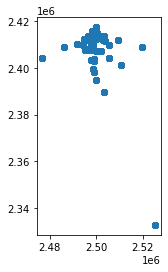

In [1168]:
gdf = gpd.GeoDataFrame(
    df_merge, 
    geometry=gpd.points_from_xy(df_merge.STRT_LONG,
                                df_merge.STRT_LAT))\
    .set_crs(4326)\
    .to_crs(3111)   
gdf.plot()

gdf = gpd.sjoin(gdf, suburbs, how='left',predicate='within')

In [1169]:
#'SSC_NAME_2016'
df_sensor = df_merge.groupby(['LOCATION_DESC'])["Total_cyclists"]\
                    .agg(sum)\
                    .sort_index(ascending=False)\
                    .sort_values()\
                    .reset_index()

df_sensor['Cyclist_percentage'] = df_sensor.apply(lambda x: \
                                    100* x.Total_cyclists/df_sensor.Total_cyclists.sum(),axis=1)


fig = go.Figure()
fig.add_trace(go.Bar(x=df_sensor.Total_cyclists, 
                       y=df_sensor.LOCATION_DESC,
                       orientation='h',
                       customdata =df_sensor.Cyclist_percentage,
                       hovertemplate =(
                           '<b>%{y}</b><br>'
                           'Total cyclists: <b>%{x:,}</b><br>'+
                           'Network share: <b>%{customdata:.1f}%<extra></extra></b>')
                      )
               )

fig.update_yaxes(title= None, showgrid = True, showticklabels = True,
                 showline=True)

fig.update_xaxes( color = '#b8b8b8',
                 showgrid = True, showticklabels = True,
                 showline=True)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.update_layout(height = 1000)
fig.update_layout(yaxis = dict(tickfont = dict(family='Arial',size=13, color = '#a0a1a3'),gridcolor='White'),
                  xaxis = dict(tickfont = dict(family='Arial',size=14, color = '#b8b8b8'),gridcolor='White'),
                  hoverlabel=dict(font=dict(family='Arial', size=14)))

fig.update_layout(hoverlabel=dict(bgcolor="white",
                                  font_size=14,
                                  font_family="Arial",
                                  font_color='#a0a1a3',
                                  bordercolor="rgba(255,255,255,255)"),
                 plot_bgcolor='#f2f2f2')
                            
#fig.update_traces(width=0.9)        
fig.update_layout(barmode='stack', bargap=0.20)
fig.update_yaxes(showticklabels=True, visible=True)
fig.layout.xaxis.side='top'
fig.show()

fig.write_html(f'{visuals}Sensor_by_volume.html')


# Overall network statistics

In [1170]:
dfm.groupby('year')[['VEHICLE','SPEED']].agg({'VEHICLE':'sum','SPEED':'mean'})

,VEHICLE,SPEED
year,,
2018,11350902,21.233452
2019,13064949,21.261042
2020,11803715,19.796726
2021,9625145,20.566091


In [1171]:
dfm.groupby('year')['VEHICLE'].sum().mean()

11461177.75

# Stacked bar chart, horizontal for relative pre-post pandemic volume

In [1172]:
df_merge['year'] = df_merge.year_M.apply(lambda x: int(x.split('-')[0]))
df_merge['month'] = df_merge.year_M.apply(lambda x: int(x.split('-')[1]))
df_merge['bi_year_split'] = df_merge.year.isin([2020,2021])\
                                         .astype(str)\
                                         .replace('False','2018-19')\
                                         .replace('True','2020-21')
# Sum up total cyclists for 2018-19 and 2020-21, excluding November and December to ensure fair comparison with 2021                                    
df_sensor = df_merge.loc[df_merge.month<11].groupby(['bi_year_split','LOCATION_DESC'])["Total_cyclists"]\
                    .agg(sum)\
                    .sort_index(ascending=False)\
                    .reset_index()


# Here we calculate the totals to use as a denominator for the percentage of cyclist traffic.
total_cyclists = df_merge.loc[df_merge.month<11].groupby('LOCATION_DESC')['Total_cyclists'].sum().reset_index()
df_sensor['Cyclist percentage'] = pd.merge(df_sensor,
                                           total_cyclists,
                                           on='LOCATION_DESC',
                                           how='left')\
                                .apply(lambda x: 100* x.Total_cyclists_x/x.Total_cyclists_y,axis=1)
# sort values on cycling percentage
df_sensor.sort_values('Cyclist percentage', ascending=False,inplace=True)

# remove 99% (ie. partial year sensors)
df_sensor = df_sensor.loc[(df_sensor['Cyclist percentage']<99)&(df_sensor['Cyclist percentage']>1)]

fig = go.Figure(go.Bar(y=df_sensor.loc[df_sensor.bi_year_split=='2018-19'].LOCATION_DESC, 
                     x=df_sensor.loc[df_sensor.bi_year_split=='2018-19']['Cyclist percentage'], 
                     legendgroup="2018-19", 
                     name="2018-19", 
                     marker_color=colours[0], 
                     marker_opacity=1.0,
                      orientation='h',
                       hovertemplate =(
                           '<b>%{y}</b><br>'
                           'Sensor volume: <b>%{x:.1f}%<extra></extra><br>')
                      )
               )


fig.add_trace(go.Bar(y=df_sensor.loc[df_sensor.bi_year_split=='2020-21'].LOCATION_DESC, 
                     x=df_sensor.loc[df_sensor.bi_year_split=='2020-21']['Cyclist percentage'], 
                     legendgroup="2020-21", 
                     name="2020-21", 
                     marker_color=colours[2], 
                     marker_opacity=1.0,
                      orientation='h',
                       hovertemplate =(
                           '<b>%{y}</b><br>'
                           'Sensor volume: <b>%{x:.1f}%<extra></extra><br>')
                      )
            )
fig.update_layout(barmode='relative')
fig.add_vline(x=50)

fig.add_annotation(x=.5,y=-.12,
                   text="Percentage of cyclists across 4 years",
                    xref="paper", yref="paper", showarrow=False,
                   font_size=14, font_color="#a0a1a3")


fig.update_layout(height = 1000)
fig.update_layout(yaxis = dict(tickfont = dict(family='Arial',size=14, color = '#b8b8b8')),
                  xaxis = dict(tickfont = dict(family='Arial',size=14, color = '#b8b8b8')),
                  hoverlabel=dict(font=dict(family='Arial', size=14)),
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_layout(hoverlabel=dict(font_size=14,
                                  font_family="Arial"))

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y= 1.03,
    xanchor="left",
    x=0.65,
    font=dict(
            family="Arial",
            size=14,
            color='#b8b8b8'
        )
))
                            
        
fig.update_layout(barmode='stack')
fig.update_yaxes(showticklabels=True, visible=True)
fig.layout.xaxis.side='bottom'

fig.update_layout(hoverlabel=dict(bgcolor="white",
                                  font_size=14,
                                  font_family="Arial",
                                  font_color='#a0a1a3',
                                  bordercolor="rgba(255,255,255,255)"))

fig.show()
fig.write_html(f'{visuals}Sensor_by_split_years_comparison.html')

In [1173]:
print(f"Top 5: {', '.join([x for x in df_sensor.loc[df_sensor.bi_year_split=='2020-21','LOCATION_DESC'].head().values])}")
print(f"Bottom 5: {', '.join([x for x in df_sensor.loc[df_sensor.bi_year_split=='2020-21','LOCATION_DESC'].tail().values])}")

Top 5: Darebin Creek Trail, Ann Trail No.3, Christmas St, Box Hill\Ringwood Trail, Federation Trail
Bottom 5: Napier St Path, Brighton Rd, Flemington Rd, Royal Pde, Wellington St


In [1174]:
colours = ['#9ca3ff','#838cfc','#636efa','#3d4bfc']

#df_sensor_2 =df_merge.groupby(['LOCATION_DESC','RGN_SHORT_NM'])["Total_cyclists"]\
#                    .agg(sum)\
#                    .sort_index(ascending=False)\
#                    .reset_index()

fig = px.treemap(df_merge, path=['LOCATION_DESC'], values="Total_cyclists",
                  color= 'RGN_SHORT_NM',
                  color_discrete_sequence=['#636efa','#9ca3ff','#636efa'])
                  #hover_data={"LOCATION_DESC":True,"Total_cyclists":'Total cyclists'})
                  #color_discrete_map={'RGN_SHORT_NM':'#9ca3ff', 'LOCATION_DESC':'#3d4bfc'})
                  #color_continuous_scale= colours,
                  #color_continuous_midpoint=np.average(df_sensor_2["Total_cyclists"], weights=df["LOCATION_DESC"]))
        
fig.update_traces(marker_line_width = 0)
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.show()

fig.write_html(f'{visuals}Treemap.html')


In [1175]:
#colours = ['#b0b7e8','#949feb','#6173e8','#364ce3']
colours = ['#9ca3ff','#838cfc','#636efa','#3d4bfc']

df_merge["Year"] = df_merge["year_M"].apply(lambda x: x.split("-")[0])
df_merge['Month'] = pd.Categorical(df_merge['year_M'].map(lambda x: months[int(x.split('-')[1])-1]),
                             categories=months, 
                             ordered=True)

#df_merge = df_merge.rename(columns={"VEHICLE":"Total_cyclists"})
#df_merge = df_merge.rename(columns={"SPEED":"Average speed (km/h)"}).round({"Average speed (km/h)":1})

fig = px.scatter(df_merge.loc[df_merge.year_M!="2021-11"], x="Average_speed", y="Total_cyclists", animation_frame= "Month", 
                 animation_group="SITE_ID",facet_col="Year",
                 color_discrete_sequence = colours,
                 size="Total_cyclists", color="Year", hover_name="SITE_DESC",
                 log_x= False, size_max=55, range_x=[5,35], range_y=[0,50000],
                 labels={"Average_speed": "Average Speed(km/hr)", "Total_cyclists": "Total Cyclists",
                               "animation_frame": "Month"},
                 hover_data={'Year':False, "SITE_DESC":True, "SITE_DESC":False,"Average_speed":':.2f',
                            'Month': False},
                )

fig.update_layout(showlegend=False, yaxis = dict(tickfont = dict(family='Arial',size=14, color = "#a0a1a3")))

fig.update_yaxes(tickfont = dict(family='Arial',size=14, color = "#a0a1a3"), gridcolor='White')
fig.update_xaxes(tickfont = dict(family='Arial',size=14, color = "#a0a1a3"), gridcolor='White',
                 #anchor = 'free',
                 #position = 1,
                 #ticklabelposition = "outside right"
                )

#fig.update_layout(xaxis={'side': 'top'})

#fig.update_layout(legend=dict(
#    orientation="h",
#    yanchor="top",
#    y=1.3,
#    xanchor="left",
#    x=0.01,
#))

#fig.update_traces(hovertemplate='Total Cyclists:<b>%{y}</b><br>Average Speed:<b>%{x}')

# remove "Year=" prefix above each plot
                               
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.for_each_xaxis(lambda x: x.update(title = ''))
fig.for_each_yaxis(lambda x: x.update(title = ''))
# and:
fig.add_annotation(x=.5,y=-.12,
                   text="Average Speed (km/h)",
                    xref="paper", yref="paper", showarrow=False,
                   font_family="Arial",
                   font_size=14, font_color="#a0a1a3")

fig.update_layout(hoverlabel=dict(bgcolor="white",
                                  font_size=14,
                                  font_family="Arial",
                                  bordercolor="rgba(255,255,255,255)"),
                 plot_bgcolor='#f2f2f2',)

fig.update_traces(hoverlabel_font_color="#a0a1a3")
fig.update_traces(marker=dict(line=dict(width = 0)))
fig.update_layout(updatemenus=[dict(type='buttons',
                  showactive=False,
                  y=-0.2,
                  x=-0,
                  xanchor='left',
                  yanchor='bottom')
                        ])

fig['layout']['sliders'][0]['pad']=dict(r= 150, t=50,)

fig.update_layout(sliders=[dict(font_color ="#a0a1a3",
                                font_family = 'Arial',
                                font_size = 14,
                                currentvalue_visible = False,
                                borderwidth=0, 
                                bgcolor='#b0b7e8',
                                activebgcolor = '#949feb',
                                tickcolor = "#a0a1a3",
                                #transition_duration = 6000,
                                #transition_easing = "linear",
                                len = 1, 
                               )])

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.update_annotations(dict(font_family = 'Arial',
                            font_color = "#a0a1a3",
                            font_size = 16))
fig.show()

fig.write_html(f'{visuals}BubbleYears.html')


<AxesSubplot:xlabel='Month'>

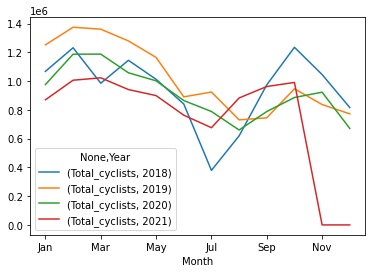

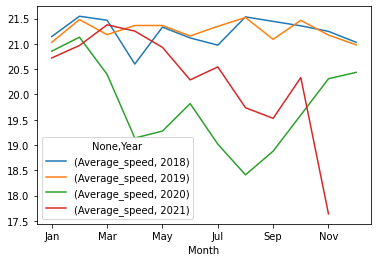

In [1176]:
df_merge.groupby(['Year','Month']).agg({'Total_cyclists':'sum'}).reset_index()\
    .pivot(index='Month',columns='Year',values=['Total_cyclists']).plot()

df_merge.groupby(['Year','Month']).agg({'Average_speed':'mean'}).reset_index()\
   .pivot(index='Month',columns='Year',values=['Average_speed']).plot()

In [1204]:
from pandas.api.types import CategoricalDtype

df_direction = df_merge.groupby(['Year', 'BEARING_DESC'])['Total_cyclists'].sum().reset_index()
cardinal_dict = {
'NORTH BOUND'      :'N',
'NORTH EAST BOUND' :'NE',
'EAST BOUND'       :'E',
'SOUTH EAST BOUND' :'SE',
'SOUTH BOUND'      :'S',
'SOUTH WEST BOUND' :'SW',
'WEST BOUND'       :'W',
'NORTH WEST BOUND' :'NW'
}
df_direction['BEARING_DESC'] = df_direction['BEARING_DESC'].apply(lambda x: cardinal_dict[x])

cardinal_dict = {k:v for k,v in zip(["N", "NE", "E", "SE", "S", "SW", "W", "NW"],
                                    [0, 45, 90, 135, 180, 225, 270, 315])}

df_direction['BEARING_DESC'] = df_direction['BEARING_DESC'].apply(lambda x: cardinal_dict[x])
#directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW',
#       'WSW', 'W', 'WNW', 'NW', 'NNW']
#df_direction['BEARING_DESC'] = df_direction['BEARING_DESC'].astype(CategoricalDtype(categories=directions,
#                                                                   ordered=True))
range_cyclists=[0,df_direction['Total_cyclists'].max()]
figs={}
years=df_direction['Year'].unique()
n_plots = len(years)
for year in years:
    figs[year] = px.bar_polar(df_direction.query(f"Year == '{year}'").sort_values('BEARING_DESC'),
                               r="Total_cyclists",
                               range_r =range_cyclists,
                               theta = "BEARING_DESC", 
                               labels = {'BEARING_DESC':'Direction'},
                               title=year)    
    
for subfig in figs:
    figs[subfig]
    figs[subfig].update_layout(
    title_font = dict(family = 'Arial', size = 16),
    #title_xanchor= "center",
    #title_yanchor= "bottom",
    polar = dict(
      radialaxis = dict(gridcolor='White'),
      angularaxis = dict(
            thetaunit = "degrees",
            dtick = 45,
            rotation=90,
            direction = "clockwise",
            tickmode="array",
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=["N", "NE", "E", "SE", "S", "SW", "W", "NW"],
            gridcolor='White'
            ),
        bgcolor='#f2f2f2',
        
    ))
    figs[subfig].show()
    pio.write_image(figs[subfig],f'{visuals}Sensor_Direction_{subfig}.svg', scale = 5)


# Let's look at lockdown!

In [1178]:
df_merge_W = pd.merge(sites, df, left_on = ['SITE_ID','TFM_ID'], right_on = ['SITE_XN_ROUTE', 'LOC_LEG'])
df_merge_W = df_merge_W.rename(columns={"VEHICLE":"Total_cyclists"})
df_merge_W = df_merge_W.rename(columns={"SPEED":"Average_speed"})
#df_merge["Year"] = df_merge["year_M"].apply(lambda x: x.split("-")[0])
#df_merge['Month'] = pd.Categorical(df_merge['year_M'].map(lambda x: months[int(x.split('-')[1])-1]),
#                             categories=months, 
#                             ordered=True)
df_merge_W = df_merge_W.set_index(['SITE_XN_ROUTE', 'LOC_LEG','year_W'])
df_merge_W.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15661 entries, (9077, 23042, Timestamp('2018-01-01 00:00:00')) to (34216, 63751, Timestamp('2021-10-25 00:00:00'))
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SITE_ID         15661 non-null  int64  
 1   TFM_ID          15661 non-null  int64  
 2   STRT_LAT        15661 non-null  float64
 3   STRT_LONG       15661 non-null  float64
 4   GPS             15587 non-null  object 
 5   SITE_NAME       15513 non-null  object 
 6   LOCATION_DESC   15661 non-null  object 
 7   SITE_DESC       15661 non-null  object 
 8   TFM_DESC        15661 non-null  object 
 9   BEARING_DESC    15661 non-null  object 
 10  DATA_SRC_CD     15661 non-null  object 
 11  RGN_SHORT_NM    15661 non-null  object 
 12  Comments        12410 non-null  object 
 13  Total_cyclists  15661 non-null  int64  
 14  Average_speed   15661 non-null  float64
 15  HEADWAY         15661 non-null  

In [1179]:
restrictions = pd.read_excel(os.path.abspath('../../data/DPC/Restriction_timeline.xlsx'), parse_dates = True)   
restrictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Start Date         20 non-null     datetime64[ns]
 1   End Date           20 non-null     datetime64[ns]
 2   Restriction        20 non-null     object        
 3   Lockdown Number    9 non-null      float64       
 4   Restriction Level  11 non-null     object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 928.0+ bytes


In [1180]:
# remove spaces in column names
restrictions = restrictions.rename(columns={x:x.replace(' ','_') for x in restrictions.columns})
restrictions

,Start_Date,End_Date,Restriction,Lockdown_Number,Restriction_Level
0,2020-03-23,2020-03-25,Partial,NaN,Stage 1
1,2020-03-26,2020-03-30,Partial,NaN,Stage 2
2,2020-03-31,2020-05-12,Full,1.0,Stage 3
3,2020-05-13,2020-05-31,Partial,NaN,NaN
4,2020-06-01,2020-06-21,Partial,NaN,NaN
5,2020-06-22,2020-07-29,Partial,NaN,NaN
6,2020-07-01,2020-07-08,Full,NaN,Stage 3
7,2020-07-09,2020-08-01,Full,2.0,Stage 3
8,2020-08-02,2020-10-18,Full,2.0,Stage 4
9,2020-10-19,2020-10-27,Full,2.0,Stage 4


In [1181]:
import sqlite3
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
df_merge_W.reset_index().to_sql('weeks', conn, index=False)
restrictions.to_sql('restrictions', conn, index=False)

qry = '''
    select  
        weeks.*,
        restrictions.*
    from
        weeks join restrictions on
        year_W between "Start_Date" and "End_Date" 
    '''
df_restrictions = pd.read_sql_query(qry, conn)
df_restrictions['year_W'] = pd.to_datetime(df_restrictions['year_W'])
df_restrictions = df_restrictions.set_index(['SITE_XN_ROUTE', 'LOC_LEG','year_W'])
df_restrictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7549 entries, (9077, 23042, Timestamp('2020-03-23 00:00:00')) to (34216, 63751, Timestamp('2021-10-25 00:00:00'))
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SITE_ID            7549 non-null   int64  
 1   TFM_ID             7549 non-null   int64  
 2   STRT_LAT           7549 non-null   float64
 3   STRT_LONG          7549 non-null   float64
 4   GPS                7549 non-null   object 
 5   SITE_NAME          7549 non-null   object 
 6   LOCATION_DESC      7549 non-null   object 
 7   SITE_DESC          7549 non-null   object 
 8   TFM_DESC           7549 non-null   object 
 9   BEARING_DESC       7549 non-null   object 
 10  DATA_SRC_CD        7549 non-null   object 
 11  RGN_SHORT_NM       7549 non-null   object 
 12  Comments           5976 non-null   object 
 13  Total_cyclists     7549 non-null   int64  
 14  Average_speed      7549 non-nu

In [1182]:
df_restrictions = pd.concat([df_restrictions,
                             df_merge_W.loc[~df_merge_W.index.isin(df_restrictions.index)]])
df_restrictions = df_restrictions[~df_restrictions.index.duplicated(keep='first')]
df_restrictions.describe()

,SITE_ID,TFM_ID,STRT_LAT,STRT_LONG,Total_cyclists,Average_speed,HEADWAY,week,year,Lockdown_Number
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,2965.000000
mean,15999.689739,56733.153630,-37.834789,144.999554,2796.792861,20.670436,1229.150566,25.055616,2019.541217,3.463744
std,11819.640580,10662.824177,0.114648,0.083958,2307.019222,4.182180,5779.320238,14.594945,1.088036,2.011552
min,6411.000000,20082.000000,-38.507720,144.736270,1.000000,1.200000,0.000000,1.000000,2018.000000,1.000000
25%,7592.000000,59451.000000,-37.834290,144.962620,917.000000,17.836357,132.278425,13.000000,2019.000000,2.000000
50%,9077.000000,59472.000000,-37.808630,144.987090,2319.000000,20.718137,218.555261,24.000000,2020.000000,2.000000
75%,32493.000000,60963.000000,-37.788280,145.033230,3962.000000,23.372032,466.435943,37.000000,2020.000000,6.000000
max,40005.000000,70011.000000,-37.743220,145.291100,11964.000000,34.790559,86400.000000,53.000000,2021.000000,6.000000


In [1183]:
df_restrictions['Restriction'] = df_restrictions['Restriction'].fillna('None')
df_restrictions['restrictions_none']=(df_restrictions.Restriction=='None').astype(int)
df_restrictions['restrictions_high']=(df_restrictions.Restriction=='Full').astype(int)
df_restrictions['restrictions_partial']=(df_restrictions.Restriction=='Partial').astype(int)
df_restrictions.head().transpose()

SITE_XN_ROUTE                                                  9077  \
LOC_LEG                                                       23042   
year_W                                                   2020-03-23   
SITE_ID                                                        9077   
TFM_ID                                                        23042   
STRT_LAT                                                 -37.809391   
STRT_LONG                                                144.974311   
GPS                                        [-37.809617 +144.977310]   
SITE_NAME                                                 D208X9077   
LOCATION_DESC                                             Albert St   
SITE_DESC                                            Albert St East   
TFM_DESC              (BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL   
BEARING_DESC                                             EAST BOUND   
DATA_SRC_CD                                                   ACBYC   
RGN_SHORT_NM                                       METRO NORTH WEST   
Comments                                                       None   
Total_cyclists                                                 2053   
Average_speed                                             22.806235   
HEADWAY                                                  308.906186   
week                                                             13   
year                                                           2020   
Start_Date                                      2020-03-23 00:00:00   
End_Date                                        2020-03-25 00:00:00   
Restriction                                                 Partial   
Lockdown_Number                                                 NaN   
Restriction_Level                                           Stage 1   
restrictions_none                                                 0   
restrictions_high                                                 0   
restrictions_partial                                              1   

SITE_XN_ROUTE                                                        \
LOC_LEG                                                               
year_W                                                   2020-03-30   
SITE_ID                                                        9077   
TFM_ID                                                        23042   
STRT_LAT                                                 -37.809391   
STRT_LONG                                                144.974311   
GPS                                        [-37.809617 +144.977310]   
SITE_NAME                                                 D208X9077   
LOCATION_DESC                                             Albert St   
SITE_DESC                                            Albert St East   
TFM_DESC              (BIKE LANE) ALBERT ST EB 50M E OF MORRISON PL   
BEARING_DESC                                             EAST BOUND   
DATA_SRC_CD                                                   ACBYC   
RGN_SHORT_NM                                       METRO NORTH WEST   
Comments                                                       None   
Total_cyclists                                                 1004   
Average_speed                                             21.919522   
HEADWAY                                                  588.400697   
week                                                             14   
year                                                           2020   
Start_Date                                      2020-03-26 00:00:00   
End_Date                                        2020-03-30 00:00:00   
Restriction                                                 Partial   
Lockdown_Number                                                 NaN   
Restriction_Level                                           Stage 2   
restrictions_none                                                 0   
restrictions_high      

<AxesSubplot:>

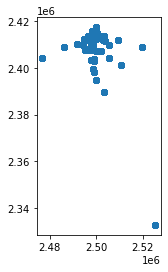

In [1184]:
# Get coordinates in metres, by first creating a geodataframe
# define input coordinate reference system as EPSG 4326 (WGS84)
# reproject to EPSG 3111 (VicGrid 94)
gdf = gpd.GeoDataFrame(
    df_restrictions, 
    geometry=gpd.points_from_xy(df_restrictions.STRT_LONG,
                                df_restrictions.STRT_LAT))\
    .set_crs(4326)\
    .to_crs(3111)   
gdf.plot()
# Note that the point isolated southeast is Port Phillip island; that's right

In [1185]:
# Representing Melb CBD as junction of Elizabeth and Bourke Streets
# from https://epsg.io/transform#s_srs=4326&t_srs=3111&x=144.9631419&y=-37.8142100
# x = 2496754.68 , y = 2409644.73
CBD_x = 2496754.68
CBD_y = 2409644.73
df_restrictions['x_metres']=gdf.geometry.x.apply(lambda x: x-CBD_x)
df_restrictions['y_metres']=gdf.geometry.y.apply(lambda y: y-CBD_y)
df_restrictions['distance_cbd_km'] = np.sqrt(df_restrictions.x_metres**2 + df_restrictions.y_metres**2)/1000
df_restrictions.describe()

,SITE_ID,TFM_ID,STRT_LAT,STRT_LONG,Total_cyclists,Average_speed,HEADWAY,week,year,Lockdown_Number,restrictions_none,restrictions_high,restrictions_partial,x_metres,y_metres,distance_cbd_km
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,2965.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,15999.689739,56733.153630,-37.834789,144.999554,2796.792861,20.670436,1229.150566,25.055616,2019.541217,3.463744,0.539621,0.189324,0.271055,3199.954205,-2288.455605,8.755842
std,11819.640580,10662.824177,0.114648,0.083958,2307.019222,4.182180,5779.320238,14.594945,1.088036,2.011552,0.498444,0.391778,0.444519,7372.290480,12731.472766,12.459901
min,6411.000000,20082.000000,-38.507720,144.736270,1.000000,1.200000,0.000000,1.000000,2018.000000,1.000000,0.000000,0.000000,0.000000,-19962.181089,-77023.498001,1.118334
25%,7592.000000,59451.000000,-37.834290,144.962620,917.000000,17.836357,132.278425,13.000000,2019.000000,2.000000,0.000000,0.000000,0.000000,-47.970701,-2229.741360,2.648575
50%,9077.000000,59472.000000,-37.808630,144.987090,2319.000000,20.718137,218.555261,24.000000,2020.000000,2.000000,1.000000,0.000000,0.000000,2109.626458,616.573864,6.334963
75%,32493.000000,60963.000000,-37.788280,145.033230,3962.000000,23.372032,466.435943,37.000000,2020.000000,6.000000,1.000000,0.000000,1.000000,6171.453485,2876.685623,8.854226
max,40005.000000,70011.000000,-37.743220,145.291100,11964.000000,34.790559,86400.000000,53.000000,2021.000000,6.000000,1.000000,1.000000,1.000000,28640.454378,7878.036170,82.175999


In [1186]:
df_restrictions.groupby('Restriction')[['Total_cyclists','Average_speed']].describe()

Total_cyclists                                                \
                     count         mean          std  min    25%     50%   
Restriction                                                                
Full                2965.0  2386.468465  1773.396973  1.0  972.0  2025.0   
None                8451.0  3159.888061  2630.912265  1.0  895.0  2556.0   
Partial             4245.0  2360.537102  1758.015303  1.0  911.0  2002.0   

                             Average_speed                                 \
                75%      max         count       mean       std       min   
Restriction                                                                 
Full         3441.0  10999.0        2965.0  19.531206  4.015664  2.928571   
None         4545.0  11964.0        8451.0  21.189062  4.178999  1.800000   
Partial      3438.0   9549.0        4245.0  20.433665  4.123929  1.200000   

                                                         
                   25%        50%        75%        max  
Restriction                                              
Full         16.986097  19.448279  22.029231  32.800000  
None         18.384421  21.525069  23.900325  34.790559  
Partial      17.841624  20.435720  22.919898  33.518349

In [1187]:
# Drawing on https://onezero.blog/fitting-mlr-and-binary-logistic-regression-using-python/

# MLR and Logistic Regession model fitting
import statsmodels.api as sm       
from statsmodels.formula.api import ols, logit

# VIF computation
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1188]:
# Correlation matrix, to evaluate multi-collinearity 
# exposures included in model shouldn't have correlation > approx .4, in general
outcomes=['Total_cyclists','Average_speed']
exposures=['restrictions_none','restrictions_partial','restrictions_high','distance_cbd_km']
correlation_matrix = df_restrictions[outcomes+exposures].corr()
correlation_matrix

,Total_cyclists,Average_speed,restrictions_none,restrictions_partial,restrictions_high,distance_cbd_km
Total_cyclists,1.000000,0.216250,0.170400,-0.115315,-0.085955,-0.331145
Average_speed,0.216250,1.000000,0.134262,-0.034524,-0.131644,-0.120740
restrictions_none,0.170400,0.134262,1.000000,-0.660189,-0.523197,-0.004274
restrictions_partial,-0.115315,-0.034524,-0.660189,1.000000,-0.294687,0.001531
restrictions_high,-0.085955,-0.131644,-0.523197,-0.294687,1.000000,0.003701
distance_cbd_km,-0.331145,-0.120740,-0.004274,0.001531,0.003701,1.000000


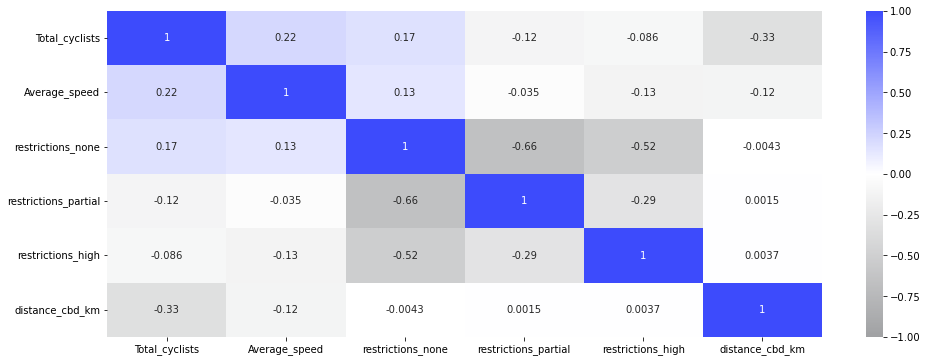

In [1189]:
# Correlation heatmap
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

colours_rgb = [tuple(int(x.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4)) for x in ['#a0a1a3','#3d4bfc']]
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=[colours_rgb[0],'white',colours_rgb[1]]
)

heatmap = sns.heatmap(correlation_matrix,  vmin=-1, vmax=1, annot=True, 
                      cmap=cmap)
#heatmap.set_title('Correlation Matrix', fontdict={'fontsize':18}, pad=16);
plt.savefig(f'{visuals}Correlation_Matrix.png') 
#pio.templates.default = "plotly_white"
#
#go.Heatmap(
#    z=correlation_matrix.mask(mask),
#    x=correlation_matrix.columns,
#    y=correlation_matrix.columns,
#    colorscale=px.colors.diverging.RdBu,
#    zmin=-1,
#    zmax=1
#)


# As observed earlier, the 2018-19 period prior to Covid19 related restrictions was weakly associated with increased average cycling speed.  Partial restrictions were not correlated with cycling speed, while a weak negative association with cycling speed was observed for high restrictions.  Distance from the CBD, as represented by the intersection of Bourke and Elizabeth St and measured using Euclidean distance in metres, also had a weak negative correlation with speed, but more so with total number of cyclists.

In [1190]:
colours_rgb = [tuple(int(x.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4)) for x in ['#a0a1a3','#3d4bfc']]
colours_rgb[0]
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=[colours_rgb[0],'white',colours_rgb[1]]
)

In [1191]:
mlr={}
mlr_estimates = {}
for outcome in outcomes:
    formula = f"{outcome} ~ {'+'.join(exposures[1:])}"
    mlr[outcome] = ols(formula, data = df_restrictions)
    mlr_estimates[outcome] = mlr[outcome].fit()
    print(mlr_estimates[outcome].summary())

                            OLS Regression Results                            
Dep. Variable:         Total_cyclists   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     837.2
Date:                Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:37:06   Log-Likelihood:            -1.4233e+05
No. Observations:               15661   AIC:                         2.847e+05
Df Residuals:                   15657   BIC:                         2.847e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3692.5693 

In [1192]:
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

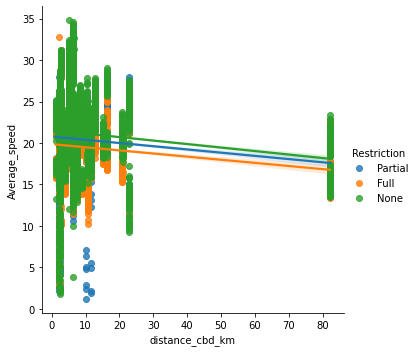

In [1193]:
sns.lmplot(x="distance_cbd_km", y="Average_speed", hue="Restriction", data=df_restrictions)

KeyError: 0

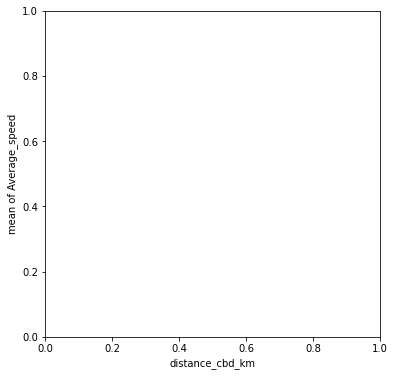

In [1194]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=df_restrictions.distance_cbd_km,
    trace=df_restrictions.restrictions_high,
    response=df_restrictions.Average_speed,
    markers=["D", "^","o"],
    ms=10,
    ax=ax,
)